In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
def plot_did(actual, predicted, diff, state):

    pre_covid_baseline = actual['2019-09-01']
    predicted_baseline = predicted['2023-06-01']
    treat_intercept_delta = 0.0005
    trend = 0
    Δ = diff['2023-03-01']  # difference in basleine and actual
    intervention_time = 0.5


    fig, ax = plt.subplots()
    point = np.linspace(1, 1, 1000)
    ti_post = np.linspace(0.5, 1.5, 1000)
    ti_pre = np.linspace(-0.5, 0.5, 1000)

    ax.plot(
        ti_post,
        predicted_baseline*point,
        color="C1",
        label="predicted baseline",
        ls=":",
    )

    ax.plot(
        ti_post,
        (predicted_baseline+Δ)*point,
        color="blue",
    )
    
    
    ax.plot(
        ti_pre,
        pre_covid_baseline*point,
        color="blue",
        label="observed",
    )
    
    ax.plot(
        ti_pre,
        pre_covid_baseline*point,
        color="C1",
        label="pre-covid baseline",
    )


    
    ax.axvline(x=intervention_time, ls="-", color="r", label="COVID19 period", lw=3)
    t = np.array([0, 1])
    
    # two blue dots
    ax.plot(
        0, 
        pre_covid_baseline,
        "o",
        color="blue",
    )

    ax.plot(
        1, 
        predicted_baseline+Δ,
        "o",
        color="blue",
    )
    
    # two orange dots
    ax.plot(
        0, 
        pre_covid_baseline,
        "o",
        color="C1",
    )
    
    ax.plot(
        1, 
        predicted_baseline,
        "o",
        color="C1",
    )
    
    
    ax.set(
        xlabel="time",
        ylabel="dWPI/dt",
        xticks=t,
        xticklabels=["pre", "post"],
        title= state+ " Q1 Difference in Differences",
    )
    ax.legend();

    plt.ylim(0, 50)
    plt.ylim(0, 1)
    plt.savefig(state+' DID.png')

C:\Users\x6023\AppData\Local\Temp\ipykernel_22596\406943784.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,i+1)


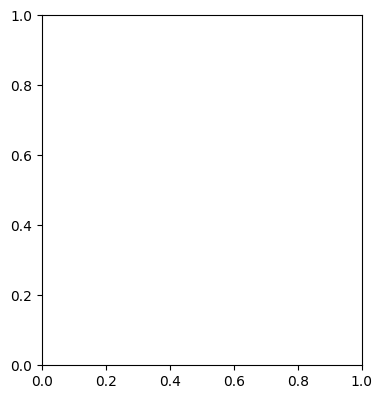

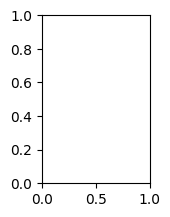

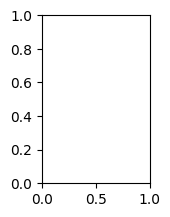

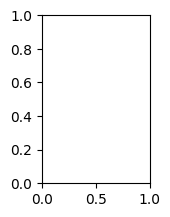

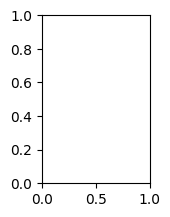

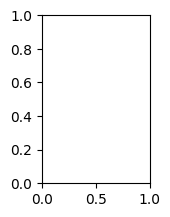

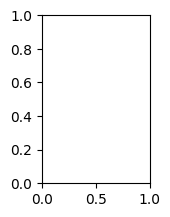

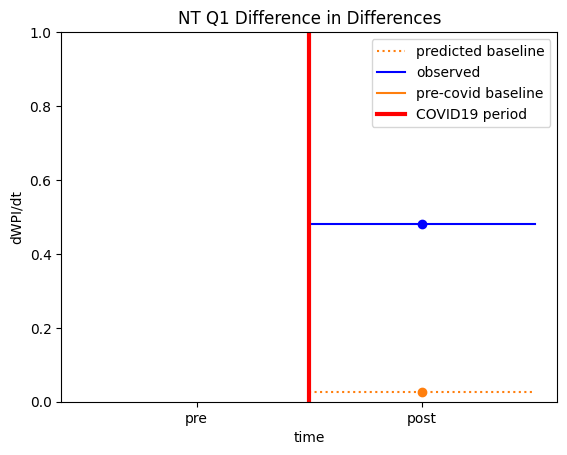

In [11]:
states = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT' ]


wages_path = 'wages.xlsx'

# actual change
wages_change = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW_actual_change','VIC_actual_change','QLD_actual_change','SA_actual_change','WA_actual_change','TAS_actual_change','NT_actual_change'])
wages_change = pd.DataFrame(wages_change)
wages_change = wages_change.set_index('time').asfreq('QS-DEC')
# Read the Excel file into a pandas DataFrame


# predicted change 
wages_predicted_change = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW_predicted_change','VIC_predicted_change','QLD_predicted_change','SA_predicted_change','WA_predicted_change','TAS_predicted_change','NT_predicted_change'])
wages_predicted_change = pd.DataFrame(wages_predicted_change)
wages_predicted_change = wages_predicted_change.set_index('time').asfreq('QS-DEC')
wages_predicted_change =wages_predicted_change.iloc[40:]

# delta
wages_change_diff = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW_change_diff','VIC_change_diff','QLD_change_diff','SA_change_diff','WA_change_diff','TAS_change_diff','NT_change_diff'])
wages_change_diff = pd.DataFrame(wages_change_diff)
wages_change_diff = wages_change_diff.set_index('time').asfreq('QS-DEC')
wages_change_diff =wages_change_diff.iloc[40:]

states_dic_predicted = dict()
states_dic_diff = dict()
states_dic_actual= dict()

for i in range(0,7):
    states_dic_actual[states[i]] = wages_change[states[i]+'_actual_change']
    states_dic_predicted[states[i]] = wages_predicted_change[states[i]+'_predicted_change']
    states_dic_diff[states[i]] = wages_change_diff[states[i]+'_change_diff']

plt.figure(figsize = (19,10))

i = 1
for state in states:
    plt.subplot(2,4,i+1)
    plot_did(states_dic_actual[state], states_dic_predicted[state], states_dic_diff[state], state)
    i = i+1

In [36]:
def plot_DID2(actual_2019, actual_2023, predict_2023):
    # 0->actual, 1->predict
    

    set_actual = pd.Series(['actual','actual','actual','actual','actual','actual','actual'], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    set_baseline = pd.Series(['baseline','baseline','baseline','baseline','baseline','baseline','baseline'], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    set_0 = pd.Series([0,0,0,0,0,0,0], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    set_1 = pd.Series([1,1,1,1,1,1,1], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])

    df = pd.DataFrame(columns=['y', 'group', 't', 'unit', 'treatment'])
    

    # baseline
    predict_2019 = actual_2019.copy()
    predict_2019['y'] = predict_2019['2019-03-01']
    predict_2019['group'] = set_actual
    predict_2019['t'] = set_0
    predict_2019['unit'] = pd.Series([0,1,2,3,4,5,6], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    predict_2019['treated'] = set_0

    predict_2023['y'] = predict_2023['2023-03-01']
    predict_2023['state'] = pd.Series(['NSW','VIC','QLD','SA','WA','TAS','NT'], index=['NSW_predicted','VIC_predicted','QLD_predicted','SA_predicted','WA_predicted','TAS_predicted','NT_predicted'])
    predict_2023 = predict_2023.set_index('state')
    predict_2023['group'] = set_actual
    predict_2023['t'] = set_1
    predict_2023['unit'] = pd.Series([0,1,2,3,4,5,6], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    predict_2023['treated'] = set_0


    # actual
    actual_2019['y'] = actual_2019['2019-03-01']
    actual_2019['group'] = set_baseline
    actual_2019['t'] = set_0
    actual_2019['unit'] = pd.Series([7,8,9,10,11,12,13], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    actual_2019['treated'] = set_1
    
    
    actual_2023['y'] = actual_2023['2023-03-01']
    actual_2023['group'] = set_baseline
    actual_2023['t'] = set_1
    actual_2023['unit'] = pd.Series([7,8,9,10,11,12,13], index=['NSW','VIC','QLD','SA','WA','TAS','NT'])
    actual_2023['treated'] = set_1

    frames = [predict_2019, predict_2023, actual_2019, actual_2023]
    result = pd.concat(frames)

    ax = sns.lineplot(result, x="t", y="y", hue="group", units="unit", estimator=None)
    sns.scatterplot(result, x="t", y="y", hue="group")
    
    ax.set_yticks([130,140,130])
    ax.set_xticks([-0.2,-0.2,1.2])


    ax.set(
        xlabel="time",
        ylabel="WPI",
        xticks=[0,1],
        xticklabels=["pre", "post"],
        title= "Overall Difference in Differences",
    )

    
    plt.savefig('state2 DID.png')

E:\Uni\research\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Uni\research\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Uni\research\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Uni\research\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

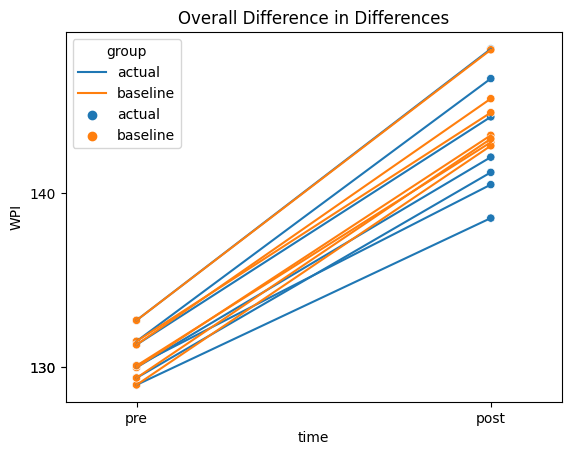

In [37]:
wages_path = 'wages.xlsx'

states = ['NSW','VIC','QLD','SA','WA','TAS','NT']

# actual observed19, baseline19 and observed23 and 
wages = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW','VIC','QLD','SA','WA','TAS','NT'])
wages = pd.DataFrame(wages)
wages = wages.set_index('time').asfreq('QS-DEC')
actual_2019 = wages.loc['2019-03-01'].to_frame()
actual_2023 = wages.loc['2023-03-01'].to_frame()


# actual baseline 23
wages_predicted = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW_predicted','VIC_predicted','QLD_predicted','SA_predicted','WA_predicted','TAS_predicted','NT_predicted'])
wages_predicted = pd.DataFrame(wages_predicted)
wages_predicted = wages_predicted.set_index('time').asfreq('QS-DEC')
predict_2023 =  wages_predicted.loc['2023-03-01'].to_frame()

# Read the Excel file into a pandas DataFrame


plot_DID2(actual_2019, actual_2023, predict_2023)

NameError: name 'plot_DID2' is not defined

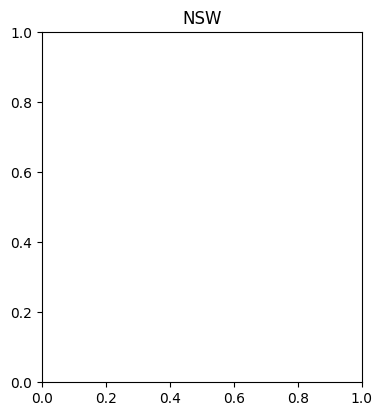

In [12]:
wages_path = 'wages.xlsx'
states = ['NSW','VIC','QLD','SA','WA','TAS','NT']

plt.figure(figsize = (19,10))

for i in range(0,7):

    state = states[i]

    # actual observed19, baseline19 and observed23 and 
    wages = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time',state])
    wages = pd.DataFrame(wages)
    wages = wages.set_index('time').asfreq('QS-DEC')
    actual_2019 = wages.loc['2019-03-01'].to_frame()
    actual_2023 = wages.loc['2023-03-01'].to_frame()
    
    
    # actual baseline 23
    wages_predicted = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time',state+'_predicted'])
    wages_predicted = pd.DataFrame(wages_predicted)
    wages_predicted = wages_predicted.set_index('time').asfreq('QS-DEC')
    predict_2023 =  wages_predicted.loc['2023-03-01'].to_frame()

    plt.subplot(2,4,i+1)
    plt.title(state)
    plot_DID2(actual_2019, actual_2023, predict_2023)




